# Adversarial VAE detection on MNIST

## Method

The adversarial VAE detector is first trained on a batch of unlabeled but normal (*not adversarial*) data. The loss is however different from traditional VAE training and focuses on minimizing the KL-divergence between a classifier's predictions on the original and reconstructed data. When an adversarial instance is fed to the VAE, the KL-divergence between the predictions on the adversarial example and the reconstruction is large. The reconstruction does not contain the adversarial artefacts and has a very different prediction distribution. As a result, the adversarial instance is flagged.

## Dataset

traffic signs

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, 
                                     Input, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1

from alibi_detect.ad import AdversarialAE
from alibi_detect.utils.fetching import fetch_detector, fetch_tf_model
from alibi_detect.utils.prediction import predict_batch
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_attack, fetch_cifar10c, corruption_types_cifar10c

In [20]:
def scale_by_instance(X: np.ndarray) -> np.ndarray:
    mean_ = X.mean(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    std_ = X.std(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    return (X - mean_) / std_, mean_, std_


def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (y_true == y_pred).astype(int).sum() / y_true.shape[0]


def plot_adversarial(idx: list,
                     X: np.ndarray,
                     y: np.ndarray,
                     X_adv: np.ndarray, 
                     y_adv: np.ndarray,
                     mean: np.ndarray, 
                     std: np.ndarray, 
                     score_x: np.ndarray = None,
                     score_x_adv: np.ndarray = None,
                     X_recon: np.ndarray = None,
                     y_recon: np.ndarray = None,
                     figsize: tuple = (10, 5)) -> None:
    
    # category map from class numbers to names
    cifar10_map = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                   6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
    
    nrows = len(idx)
    ncols = 3 if isinstance(X_recon, np.ndarray) else 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    n_subplot = 1
    for i in idx:
        
        # rescale images in [0, 1]
        X_adj = (X[i] * std[i] + mean[i]) / 255
        X_adv_adj = (X_adv[i] * std[i] + mean[i]) / 255
        if isinstance(X_recon, np.ndarray):
            X_recon_adj = (X_recon[i] * std[i] + mean[i]) / 255
        
        # original image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if isinstance(score_x, np.ndarray):
                plt.title('CIFAR-10 Image \n{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('CIFAR-10 Image \n{}'.format(cifar10_map[y[i]]))
        else:
            if isinstance(score_x, np.ndarray):
                plt.title('{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('{}'.format(cifar10_map[y[i]]))
        plt.imshow(X_adj)
        n_subplot += 1
        
        # adversarial image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if isinstance(score_x_adv, np.ndarray):
                plt.title('Adversarial \n{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('Adversarial \n{}'.format(cifar10_map[y_adv[i]]))
        else:
            if isinstance(score_x_adv, np.ndarray):
                plt.title('{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('{}'.format(cifar10_map[y_adv[i]]))
        plt.imshow(X_adv_adj)
        n_subplot += 1
     
        # reconstructed image
        if isinstance(X_recon, np.ndarray):
            plt.subplot(nrows, ncols, n_subplot)
            plt.axis('off')
            if i == idx[0]:
                plt.title('AE Reconstruction \n{}'.format(cifar10_map[y_recon[i]]))
            else:
                plt.title('{}'.format(cifar10_map[y_recon[i]]))
            plt.imshow(X_recon_adj)
            n_subplot += 1
    
    plt.show()

    
def plot_roc(roc_data: dict, figsize: tuple = (10,5)):
    plot_labels = []
    scores_attacks = []
    labels_attacks = []
    for k, v in roc_data.items():
        if 'original' in k:
            continue
        score_x = roc_data[v['normal']]['scores']
        y_pred = roc_data[v['normal']]['predictions']
        score_v = v['scores']
        y_pred_v = v['predictions']
        labels_v = np.ones(score_x.shape[0])
        idx_remove = np.where(y_pred == y_pred_v)[0]
        labels_v = np.delete(labels_v, idx_remove)
        score_v = np.delete(score_v, idx_remove)
        scores = np.concatenate([score_x, score_v])
        labels = np.concatenate([np.zeros(y_pred.shape[0]), labels_v]).astype(int)
        scores_attacks.append(scores)
        labels_attacks.append(labels)
        plot_labels.append(k)
    
    for sc_att, la_att, plt_la in zip(scores_attacks, labels_attacks, plot_labels):
        fpr, tpr, thresholds = roc_curve(la_att, sc_att)
        roc_auc = auc(fpr, tpr)
        label = str('{}: AUC = {:.2f}'.format(plt_la, roc_auc))
        plt.plot(fpr, tpr, lw=1, label='{}: AUC={:.4f}'.format(plt_la, roc_auc))

    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}'.format('ROC curve'))
    plt.legend(loc="lower right", ncol=1)
    plt.grid()
    plt.show()

In [21]:
from sklearn.metrics import confusion_matrix
%set_env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


# Mnist model

## Load data

In [22]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
#X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
#X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


### Show example

Sample instance from the signs data set.


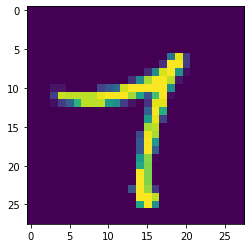

In [23]:
idx = 4200
x = X_train[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the signs data set.')

## Create and train mnist model

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can either manually download the relevant files in the [model_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/model_mnist/) folder to e.g. the local directory ```my_dir```. Alternatively,  if you have [Google Cloud SDK](https://cloud.google.com/sdk/docs/) installed, you can download the whole folder as follows:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/model_mnist my_dir
```

In [24]:
load_model = False
model_dir = '/home/gio/adversarial_vae/adversarial-vae/models/classifier/mnist/model/'

In [25]:
filepath = model_dir
if load_model:
    model = tf.keras.models.load_model('/home/gio/adversarial_vae/adversarial-vae/models/classifier/mnist/model/model.h5')
else:

    inputs = Input(shape=(X_train.shape[1:]))
    x = Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu')(inputs)
    x = Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model

    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    
    # save model
    save_tf_model(model, filepath)

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 5s 86us/sample - loss: 0.4052 - accuracy: 0.8698 - val_loss: 0.0688 - val_accuracy: 0.9765
Epoch 2/6
60000/60000 [==============================] - 3s 50us/sample - loss: 0.1107 - accuracy: 0.9648 - val_loss: 0.0432 - val_accuracy: 0.9848
Epoch 3/6
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0849 - accuracy: 0.9745 - val_loss: 0.0338 - val_accuracy: 0.9884
Epoch 4/6
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0695 - accuracy: 0.9785 - val_loss: 0.0285 - val_accuracy: 0.9897
Epoch 5/6
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0612 - accuracy: 0.9809 - val_loss: 0.0270 - val_accuracy: 0.9915
Epoch 6/6
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0523 - accuracy: 0.9836 - val_loss: 0.0253 - val_accuracy: 0.9914


NameError: name 'save_tf_model' is not defined

In [26]:
# evaluate model
results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 0.0253 -- accuracy: 0.9914


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        16448     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 32)        8224      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        4128  

In [28]:
probs = model(X_test).numpy()

In [29]:
probs.shape

(10000, 10)

In [30]:
probs.max(axis=1).mean()

0.99091536

In [31]:
# C&W attack
data_cw = fetch_attack('mnist', 'mnist', 'cw')
X_train_cw, X_test_cw = data_cw['data_train'], data_cw['data_test']
meta_cw = data_cw['meta'] # metadata with hyperparameters of the attack

ValueError: Cannot load file containing pickled data when allow_pickle=False

# Generate adversarial instances

The `cleverhans` adversarial attack methods assume that the model outputs logits, so we will create a modified model by simply removing the softmax output layer:

In [13]:
def generate_adv_example(model, X_test, y_test, X_train,
                         method = 'fgsm', ad_loss_w = 0.1, eps=2, eps_iter=1, nb_iter=10,
                         nb_adv = 1000, ad=None):
    
    model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    ids = np.arange(nb_adv)
    np.random.shuffle(ids)
    X_to_adv = X_test[ids]
    y_adv = y_test[ids]
    #print(X_to_adv.shape)
    
    if method == 'pfgsm':
        X_adv = projected_gradient_descent(model_logits, ad, ad_loss_w,
                                   X_to_adv,
                                   eps=eps,
                                   eps_iter=eps_iter,
                                   nb_iter=nb_iter,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()
    elif method == 'fgsm':
        X_adv = fast_gradient_method(model_logits, 
                                     X_to_adv, 
                                     eps=eps, 
                                     norm=2, 
                                     clip_min=X_train.min(), 
                                     clip_max=X_train.max(), 
                                     y=None,
                                     targeted=False, 
                                     sanity_checks=False).numpy()
    
    return X_to_adv, X_adv, np.argmax(y_adv, axis=1)

def generate_adv_set(X_to_adv, X_adv):
    y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
    y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
    
    X_to_adv = X_to_adv[(y_pred != y_pred_adv)]
    X_adv = X_adv[(y_pred != y_pred_adv)]
    
    y_pred = ad.predict(X_to_adv)['data']['is_adversarial']
    y_pred_adv = ad.predict(X_adv)['data']['is_adversarial']
    
    X_val = np.concatenate((X_to_adv, X_adv), axis=0)
    y_val = np.concatenate((np.zeros(len(X_to_adv)), np.ones(len(X_adv))))
    preds_val = np.concatenate([y_pred, y_pred_adv], axis=0)
    #print(X_val.shape, y_val.shape)
    
    return X_val, y_val


In [14]:
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [15]:
nb_adv = 1000
ids = np.arange(nb_adv)
np.random.shuffle(ids)
X_to_adv = X_test[ids]
y_adv = y_test[ids]
print(X_to_adv.shape)

(1000, 28, 28, 1)


In [20]:
fmodel = foolbox.models.KerasModel(model, bounds=(0, 1))

Using TensorFlow backend.


In [27]:
from foolbox.criteria import TargetClassProbability, ConfidentMisclassification

In [2]:
labels = np.argmax(fmodel.forward(X_to_adv), axis=1)
attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel)
X_adv = attack(X_to_adv, labels, confidence=0.9)

NameError: name 'np' is not defined

In [177]:
X_to_adv = X_test[:100]

In [178]:
X_adv = X_adv_test[:100]

In [32]:
X_adv = projected_gradient_descent(model_logits, None, 0,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False).numpy()

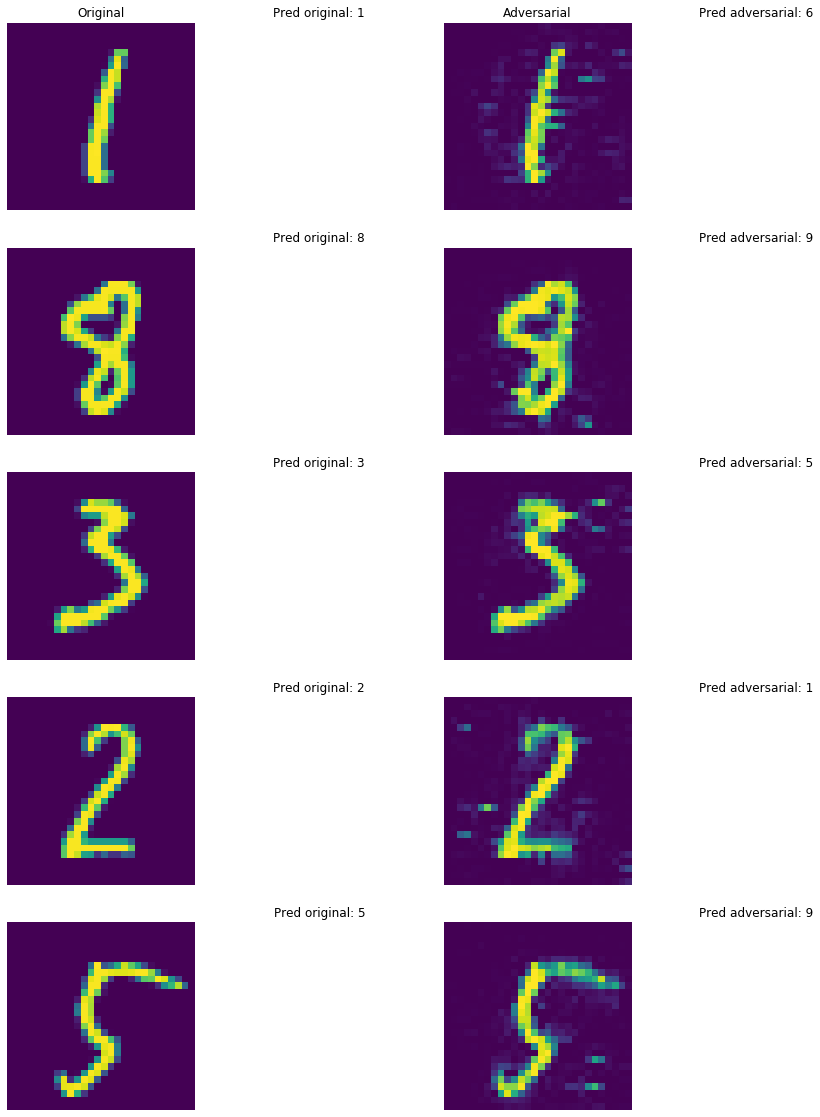

In [33]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (28, 28)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    #class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    #image = Image.fromarray(class_image, 'RGB')
    #image = np.array(image)
    #ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    #class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    #image_adv = Image.fromarray(class_image_adv, 'RGB')
    #image_adv = np.array(image_adv)   
    #ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

In [34]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)

X_to_adv = X_to_adv[(y_pred != y_pred_adv)]
X_adv = X_adv[(y_pred != y_pred_adv)]
#y_adv = y_adv[(y_pred != y_pred_adv)]
#y_adv = np.argmax(y_adv, axis=1)

In [35]:
y_val = np.concatenate((np.zeros(len(X_to_adv)), np.ones(len(X_adv))))
X_val = np.concatenate([X_to_adv, X_adv], axis=0)
print(X_val.shape, y_val.shape, y_adv.shape)

(1904, 28, 28, 1) (1904,) (1000, 10)


In [36]:
nb_adv = int(X_val.shape[0] / 2)

# Adversarial detection 

## Adversarial VAE for MNIST

You can again either manually download the relevant files in the [ad_vae_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad_vae_mnist/) folder to e.g. the local directory ```my_dir``` or use ```gsutil```:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/ad_vae_mnist my_dir
```

In [16]:
load_adversarial_detector = False

### Run training cell

---

In [17]:
filepath

'/home/gio/experiments/mnist/model_0/'

In [18]:
encoder_params = {'nb_filters_1': 64, 'nb_filters_2': 128, 'nb_filters_3': 512,
               'kernel_1': 4, 'kernel_2': 4, 'kernel_3': 4,
               'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu',
                'padding_1': 'same', 'padding_2': 'same', 'padding_3': 'same'}
decoder_params = {'nb_filters_1': 64, 'nb_filters_2': 32, 'nb_filters_3': 1,
               'kernel_1': 3, 'kernel_2': 3, 'kernel_3': 3, 
               'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'sigmoid',
               'padding_1': 'same', 'padding_2': 'same', 'padding_3': 'same',}
vae_params = {'latent_dim': 160, 'optimizer': 'Adam'}

filepath = detector_dir # change to directory where model is downloaded
if load_adversarial_detector:  # load pretrained adversarial detector
    ad = load_detector(filepath)
else:  # define model, initialize, train and save adversarial detector
    latent_dim = vae_params['latent_dim']
    alpha = 0.001
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(28, 28, 1)),
          #Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=1, 
          #       padding=encoder_params['padding_1'], activation=encoder_params['activation_1'],
          #      kernel_regularizer=l2(alpha)),
          Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_1'],
                kernel_regularizer=l2(alpha)),
          Conv2D(encoder_params['nb_filters_2'], encoder_params['kernel_2'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_2'],
                kernel_regularizer=l2(alpha)),
          Conv2D(encoder_params['nb_filters_3'], encoder_params['kernel_3'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_3'],
                kernel_regularizer=l2(alpha))
      ])
    
    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(7*7*28, activation=tf.nn.relu),
          Reshape(target_shape=(7, 7, 28)),
          Conv2DTranspose(decoder_params['nb_filters_1'], decoder_params['kernel_1'], strides=2, 
                         padding=decoder_params['padding_1'], activation=decoder_params['activation_1'],
                         kernel_regularizer=l2(alpha)),
          Conv2DTranspose(decoder_params['nb_filters_2'], decoder_params['kernel_2'], strides=2, 
                          padding=decoder_params['padding_1'], activation=decoder_params['activation_2'],
                         kernel_regularizer=l2(alpha)),
          Conv2DTranspose(decoder_params['nb_filters_3'], decoder_params['kernel_3'], strides=1, 
                          padding=decoder_params['padding_1'], activation=decoder_params['activation_3'],
                         kernel_regularizer=l2(alpha))
      ])

    runs = next(os.walk(log_dir))[1]
    run_id = 0
    while str(run_id) in runs:
        run_id += 1

    run_dir = log_dir + str(run_id)
    print('Creating log dir:', run_dir)
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)    
    
    if vae_params['optimizer'] == 'Adam':
        opt = Adam()
    elif vae_params['optimizer'] == 'Nadam':
        opt = Nadam()
    elif vae_params['optimizer'] == 'RMSprop':
        opt = RMSprop()
    elif vae_params['optimizer'] == 'SGD':
        opt = SGD(momentum=0.9)
    
    # initialize adversarial detector
    ad = AdversarialVAE(threshold=.5,  # threshold for adversarial score
                        model=model,
                        encoder_net=encoder_net,  # can also pass VAE model instead
                        decoder_net=decoder_net,  # of separate encoder and decoder
                        latent_dim=latent_dim,
                        samples=2,  # nb of samples drawn by VAE
                        beta=0.  # weight on KL-divergence loss term of latent space
                       )
    


Creating log dir: /home/gio/experiments/mnist/model_0/vae_0/115


In [19]:
opt

In [45]:
    # train
    ad.fit(X_train,
           validation_data=(X_test[:1000], None),
           adversarial_data=(X_val, y_val),
           loss_fn=loss_adv_vae,
           w_model=1.,  # weight on KL-divergence loss term of model predictions
           w_recon=0.,  # weight on elbo loss term
           optimizer=opt,
           epochs=6,
           verbose=True,
          log_metric_val='acc',
          log_dir=run_dir)

938/938 [=] - 36s 39ms/step - loss: 0.4756
Accuracy improved from 0 to 0.8713. Saving model in /home/gio/experiments/mnist/model_0/vae_0/104/best.ckpt
938/938 [=] - 36s 38ms/step - loss: 0.1689
Accuracy did not improve. Saving model in /home/gio/experiments/mnist/model_0/vae_0/104/last.ckpt 
938/938 [=] - 36s 38ms/step - loss: 0.1291
Accuracy did not improve. Saving model in /home/gio/experiments/mnist/model_0/vae_0/104/last.ckpt 
938/938 [=] - 36s 38ms/step - loss: 0.1089
Accuracy improved from 0.8713 to 0.8787. Saving model in /home/gio/experiments/mnist/model_0/vae_0/104/best.ckpt
938/938 [=] - 36s 38ms/step - loss: 0.0966
Accuracy improved from 0.8787 to 0.9018. Saving model in /home/gio/experiments/mnist/model_0/vae_0/104/best.ckpt
938/938 [=] - 36s 38ms/step - loss: 0.0868
Accuracy improved from 0.9018 to 0.9259. Saving model in /home/gio/experiments/mnist/model_0/vae_0/104/best.ckpt
939/938 [=] - 37s 39ms/step - loss: 0.0868 - detection_acc: 0.9259 - detection_f1: 0.9289


In [47]:
    # save the trained outlier detector
    save_detector(ad, filepath)
    

with open(os.path.join(run_dir,'encoder_params.json'), 'w') as f:
        json.dump(encoder_params, f)
        f.close()
    with open(os.path.join(run_dir,'decoder_params.json'), 'w') as f:
        json.dump(decoder_params, f)
        f.close()
    with open(os.path.join(run_dir,'vae_params.json'), 'w') as f:
        json.dump(vae_params, f)
        f.close()

---

In [48]:
df_adv_scores = pd.read_csv('/home/gio/experiments/mnist/model_0/vae_0/104/adv_scores.csv')
df_scores = pd.read_csv('/home/gio/experiments/mnist/model_0/vae_0/104/scores.csv')
df_losses = pd.read_csv('/home/gio/experiments/mnist/model_0/vae_0/104/losses.csv')

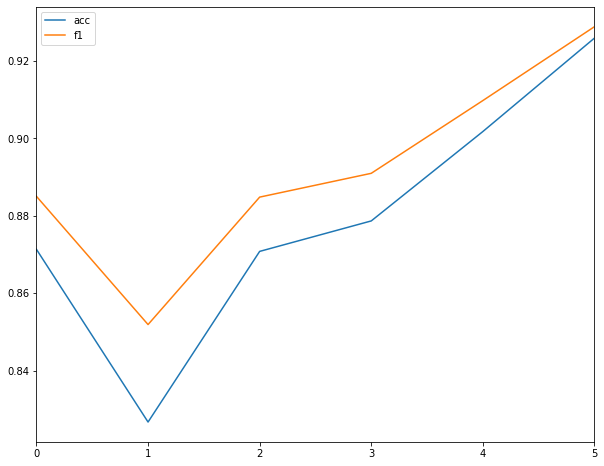

In [49]:
df_scores[['acc', 'f1']].plot(figsize=(10, 8))

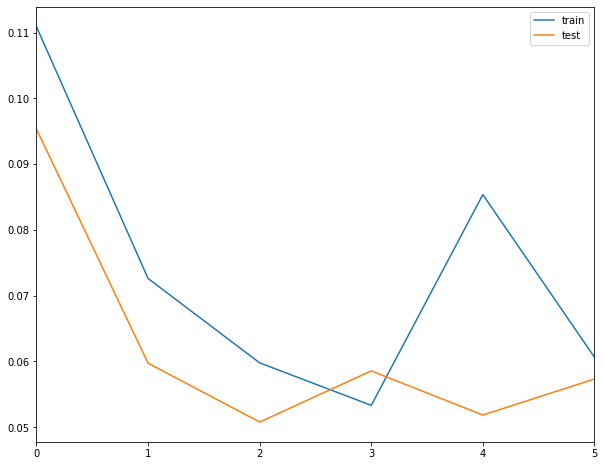

In [50]:
df_losses.plot(figsize=(10, 8))

In [51]:
#df_adv_scores[df_adv_scores['labels']==0].mean()

In [52]:
#df_adv_scores[df_adv_scores['labels']==1].mean()

## Detect adversarial instances

In [20]:
ad.vae.load_weights('/home/gio/experiments/mnist/model_0/vae_0/104/best.ckpt')
ad.ae = ad.vae
ad.infer_threshold(X_train[:2000], threshold_perc=95.)
ad.threshold

0.1570185706019401

In [21]:
X_to_adv = X_test[:5]
y_adv = y_test[:5]

In [22]:
y_adv = np.argmax(y_adv, axis=1)

In [23]:
ad.ae(X_to_adv)

<tf.Tensor: id=1974, shape=(5, 28, 28, 1), dtype=float32, numpy=
array([[[[5.80655694e-01],
         [5.78343630e-01],
         [6.31177962e-01],
         ...,
         [3.78304243e-01],
         [5.72310209e-01],
         [3.52522552e-01]],

        [[5.31215131e-01],
         [5.08665025e-01],
         [3.08091372e-01],
         ...,
         [2.77273178e-01],
         [3.21504653e-01],
         [3.57126474e-01]],

        [[3.87855411e-01],
         [1.84966892e-01],
         [2.45111018e-01],
         ...,
         [8.85563195e-02],
         [3.10084313e-01],
         [1.94887370e-01]],

        ...,

        [[7.57237792e-01],
         [6.91856503e-01],
         [3.73332381e-01],
         ...,
         [2.32969820e-02],
         [1.27363890e-01],
         [7.85171986e-02]],

        [[6.78770244e-01],
         [1.58981591e-01],
         [1.65551662e-01],
         ...,
         [1.62810147e-01],
         [3.45813364e-01],
         [2.09892571e-01]],

        [[2.92607069e-01],
    

In [24]:
attack_type = 'carlini'
import logging
logging.basicConfig(level=logging.WARNING)

In [26]:
inputsAE = Input(shape=(X_train.shape[1:]))
xAE = ad.ae(inputsAE)
outputsAE = model(xAE)
modelAE = Model(inputs=inputsAE, outputs=outputsAE)
modelAE.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


In [27]:
        fmodel = foolbox.models.TensorFlowEagerModel(modelAE, bounds=(0, 1), preprocessing=(0, 1))
        attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel)
        X_adv = attack(X_to_adv, y_adv, detector=ad, loss_w=0.1)

/home/gio/git/foolbox-fork/foolbox/attacks/base.py:95: UserWarning: CarliniWagnerL2Attack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())
/home/gio/git/foolbox-fork/foolbox/attacks/base.py:95: UserWarning: CarliniWagnerL2Attack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())
INFO:root:2 of 5 attacks completed
/home/gio/git/foolbox-fork/foolbox/attacks/base.py:95: UserWarning: CarliniWagnerL2Attack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())
/home/gio/git/foolbox-fork/foolbox/attacks/base.py:95: UserWarning: CarliniWagnerL2Attack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())
INFO:root:4 of 5 attacks completed
/home/gio/git/foolbox-fork/foolbox/attacks/base.py:95: Use

In [28]:
    preds_xtoadv = np.argmax(model(X_to_adv).numpy(), axis=1)
    preds_adv = np.argmax(model(X_adv).numpy(), axis=1)
    #loss_ws.append(loss_w)
    print(X_to_adv.shape, X_adv.shape)
    print(preds_xtoadv.shape, preds_adv.shape)
    print(accuracy_score(preds_xtoadv, y_adv))
    print(accuracy_score(preds_adv, y_adv))
    

(5, 28, 28, 1) (5, 28, 28, 1)
(5,) (5,)
1.0
0.2


In [32]:
np.isnan(X_adv).all()

True

In [131]:
ad.model(X_adv).numpy()

array([[9.63939875e-02, 2.18440652e-01, 9.27550048e-02, 8.06015432e-02,
        7.92437121e-02, 9.77875590e-02, 8.37877914e-02, 1.16489962e-01,
        5.60058653e-02, 7.84939006e-02],
       [9.63939875e-02, 2.18440652e-01, 9.27550048e-02, 8.06015432e-02,
        7.92437121e-02, 9.77875590e-02, 8.37877914e-02, 1.16489962e-01,
        5.60058653e-02, 7.84939006e-02],
       [9.63939875e-02, 2.18440652e-01, 9.27550048e-02, 8.06015432e-02,
        7.92437121e-02, 9.77875590e-02, 8.37877914e-02, 1.16489962e-01,
        5.60058653e-02, 7.84939006e-02],
       [9.63939875e-02, 2.18440652e-01, 9.27550048e-02, 8.06015432e-02,
        7.92437121e-02, 9.77875590e-02, 8.37877914e-02, 1.16489962e-01,
        5.60058653e-02, 7.84939006e-02],
       [9.63939875e-02, 2.18440652e-01, 9.27550048e-02, 8.06015432e-02,
        7.92437121e-02, 9.77875590e-02, 8.37877914e-02, 1.16489962e-01,
        5.60058653e-02, 7.84939006e-02],
       [9.63939875e-02, 2.18440652e-01, 9.27550048e-02, 8.06015432e-02,
   

In [136]:
np.isnan(X_adv).astype(int).sum()/ (28 * 28)

74.0

In [40]:
attack_type = 'pfgsm'

In [106]:
loss_ws, accs_no_attack, accs_attack, accs_defence, roc_curves, aucs, adv_scores = [], [], [], [], [], [], []
print('Attacking ...')
#for loss_w in np.arange(0.01, 1.0, 0.01):
if True:
    loss_w = 0.1
    print('ad loss weight:', loss_w)
    if attack_type == 'carlini':
        fmodel = foolbox.models.TensorFlowEagerModel(model, bounds=(0, 1))
        labels_test = np.argmax(fmodel.forward(X_to_adv), axis=1)
        attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel)
        X_adv = attack(X_to_adv, labels_test, detector=ad, loss_w=loss_w)
    elif attack_type == 'pfgsm':
        X_adv = projected_gradient_descent(model_logits, ad, loss_w,
                                       X_to_adv,
                                   eps=1.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False).numpy()
    #X_concat = np.concatenate((X_to_adv, X_adv))
    #preds_concat = np.concatenate((preds_xtoadv, preds_adv))
    #y_adv_concat = np. concatenate((y_adv, y_adv))
    preds_xtoadv = np.argmax(model(X_to_adv).numpy(), axis=1)
    preds_adv = np.argmax(model(X_adv).numpy(), axis=1)
    loss_ws.append(loss_w)
    print(X_to_adv.shape, X_adv.shape)
    print(preds_xtoadv.shape, preds_adv.shape)
    accs_no_attack.append(accuracy_score(preds_xtoadv, y_adv))
    accs_attack.append(accuracy_score(preds_adv, y_adv))
    
    nb_rep = 10
    nb_classes = 10
    nb_samples = len(X_adv)
    concatenation = tuple([X_adv for _ in range(nb_rep)])
    shape_0 = (X_adv.shape[0], nb_rep) + X_adv.shape[1:]
    X_adv_conc = np.concatenate(concatenation, axis=1).reshape(shape_0)
    shape_1 = (X_adv_conc.shape[0] * X_adv_conc.shape[1], ) + X_adv_conc.shape[2:]
    X_adv_fin = X_adv_conc.reshape(shape_1)
    
    preds_adv_trans = model.predict(ad.vae(X_adv_fin).numpy())
    preds_adv_trans = preds_adv_trans.reshape(nb_samples, nb_rep, nb_classes)
    #preds_fin = mode(np. argmax(preds_adv_trans, axis=1), axis=1)[0]
    preds_fin = np.mean(preds_adv_trans, axis=1)
    preds_fin = np.argmax(preds_fin, axis=1)

    accs_defence.append(accuracy_score(preds_fin, y_adv))
    
    kl_test_dict = ad.predict(X_to_adv, return_instance_score=True)
    kl_test = kl_test_dict['data']['instance_score']
    kl_adv_dict = ad.predict(X_adv, return_instance_score=True)
    kl_adv = kl_adv_dict['data']['instance_score']
    perm = np.random.permutation(range(len(kl_adv)))[:]
    x_kl = np.concatenate((kl_test, kl_adv[perm]))
    y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv[perm]))))
    x_kl = x_kl / x_kl.max()
    print('Vae detector')
    roc = roc_curve(y_kl, x_kl)
    roc_curves.append(roc)
    auc = roc_auc_score(y_kl, x_kl)
    aucs.append(auc)
    adv_scores.append(ad.score(X_adv).mean())
print('Done!')
df = pd.DataFrame()
df['loss_w'] = loss_ws
df['acc_no_attack'] = accs_no_attack
df['acc_attack'] = accs_attack
df['acc_defence'] = accs_defence
df['auc'] = aucs
df.set_index('loss_w', inplace=True)

Attacking ...
ad loss weight: 0.1
(100, 28, 28, 1) (100, 28, 28, 1)
(100,) (100,)
Vae detector
Done!


detector loss with + sign


/home/gio/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


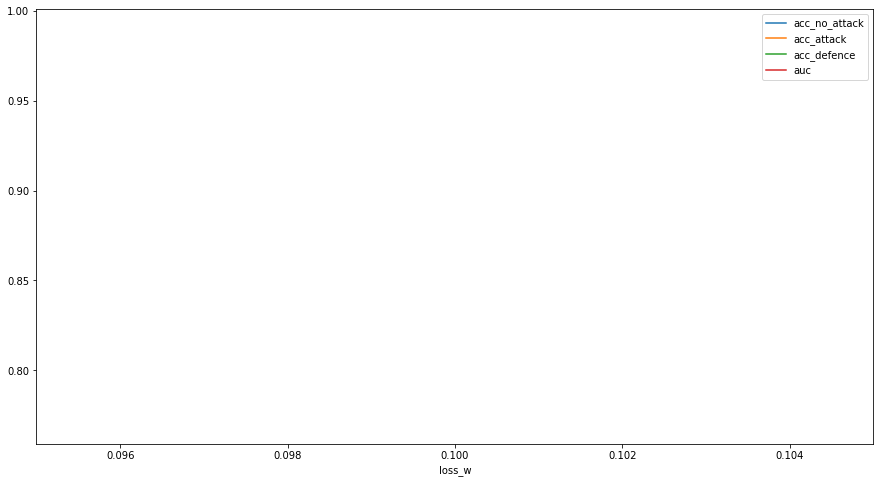

In [107]:
print('detector loss with + sign')
df.plot(figsize=(15, 8))

In [108]:
df

,acc_no_attack,acc_attack,acc_defence,auc
loss_w,,,,
0.1,0.99,0.77,0.81,0.9315


In [109]:
adv_scores

[1.3837821]

In [110]:
ad.score(X_adv).mean()

1.3697493

(0.0, 1.0)

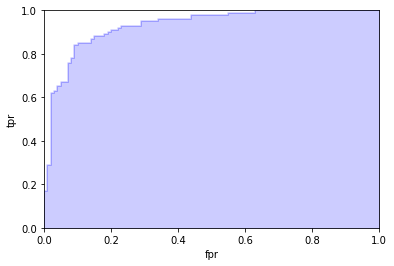

In [111]:
fpr, tpr, thresholds = roc_curves[-1]

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
plt.fill_between(fpr, tpr, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

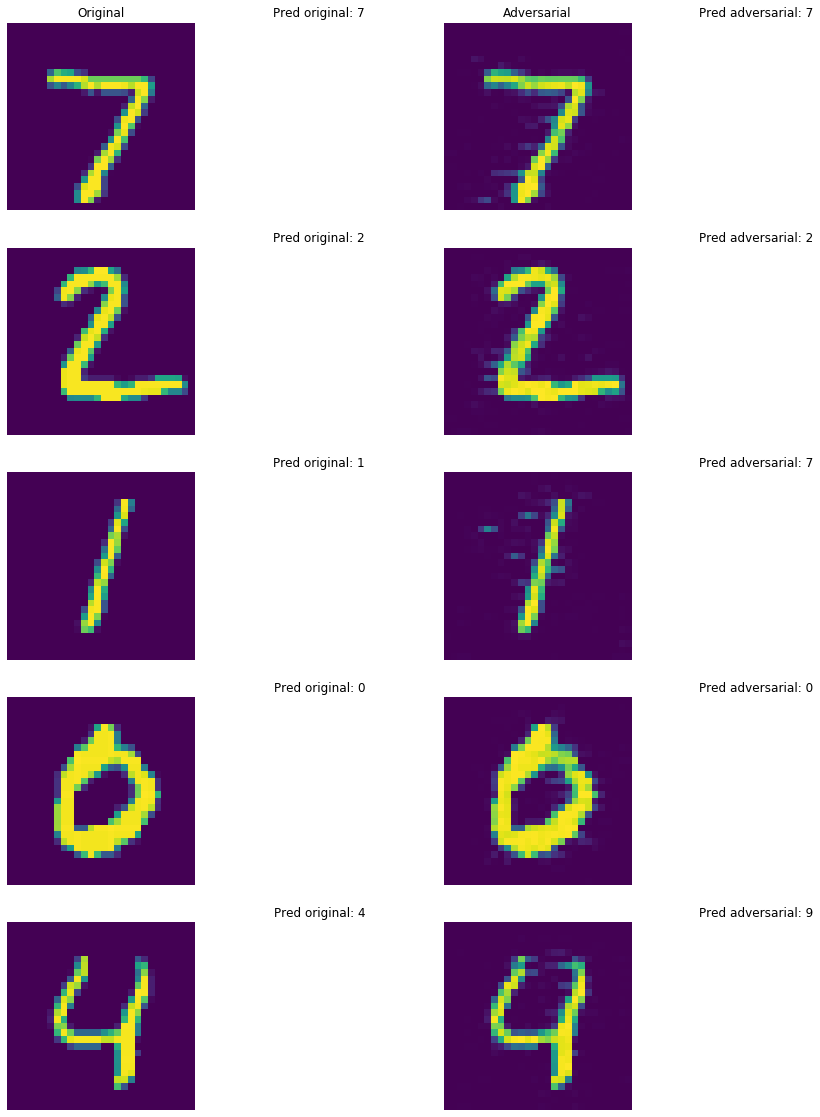

In [112]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (28, 28)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    #class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    #image = Image.fromarray(class_image, 'RGB')
    #image = np.array(image)
    #ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    #class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    #image_adv = Image.fromarray(class_image_adv, 'RGB')
    #image_adv = np.array(image_adv)   
    #ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

In [113]:
#print('detector loss with - sign')
#df.plot(figsize=(15, 8))

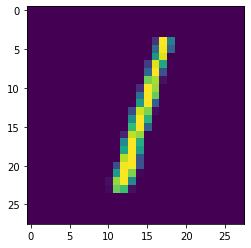

In [114]:
plt.imshow(X_to_adv[2].reshape(28, 28))

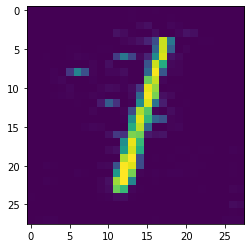

In [115]:
plt.imshow(X_adv[2].reshape(28, 28))

In [116]:
ad.model(X_to_adv[0].reshape(1, 28, 28, 1)).numpy()

array([[8.5402831e-12, 5.1244164e-10, 8.7334566e-09, 1.1344794e-06,
        3.8656255e-11, 4.4143630e-11, 1.0448275e-15, 9.9999821e-01,
        1.2212321e-10, 5.6244414e-07]], dtype=float32)

In [117]:
ad.model(X_adv[0].reshape(1, 28, 28, 1)).numpy()

array([[3.73621756e-09, 3.01709463e-07, 7.85286829e-06, 6.64275810e-02,
        4.51988633e-08, 3.86506872e-06, 1.26284296e-11, 9.32868481e-01,
        1.45359152e-07, 6.91762660e-04]], dtype=float32)

In [118]:
ad.model(ad.vae(X_to_adv[0].reshape(1, 28, 28, 1)).numpy()).numpy()

array([[3.3952979e-08, 1.1243275e-06, 1.4020694e-06, 1.4916682e-06,
        6.7045676e-07, 1.6184002e-08, 1.2886536e-11, 9.9997580e-01,
        2.5469529e-10, 1.9480578e-05]], dtype=float32)

In [119]:
ad.model(ad.vae(X_adv[0].reshape(1, 28, 28, 1)).numpy()).numpy()

array([[1.6172150e-07, 2.0257539e-06, 6.8822415e-06, 1.3893086e-05,
        9.9299211e-07, 7.5131993e-08, 5.6160201e-11, 9.9985218e-01,
        2.0715962e-09, 1.2377153e-04]], dtype=float32)

In [204]:
ad_preds = ad.predict(X_val, return_instance_score=True)
y_pred = ad_preds['data']['is_adversarial']

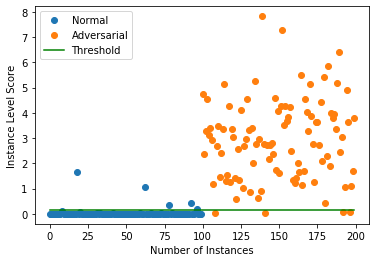

In [205]:
labels = ['Normal', 'Adversarial']
target = np.array([0 if i < X_to_adv.shape[0] else 1 for i in range(X_val.shape[0])])
plot_instance_score(ad_preds, target, labels, ad.threshold)

In [206]:
accuracy_score(y_val, y_pred)

0.955

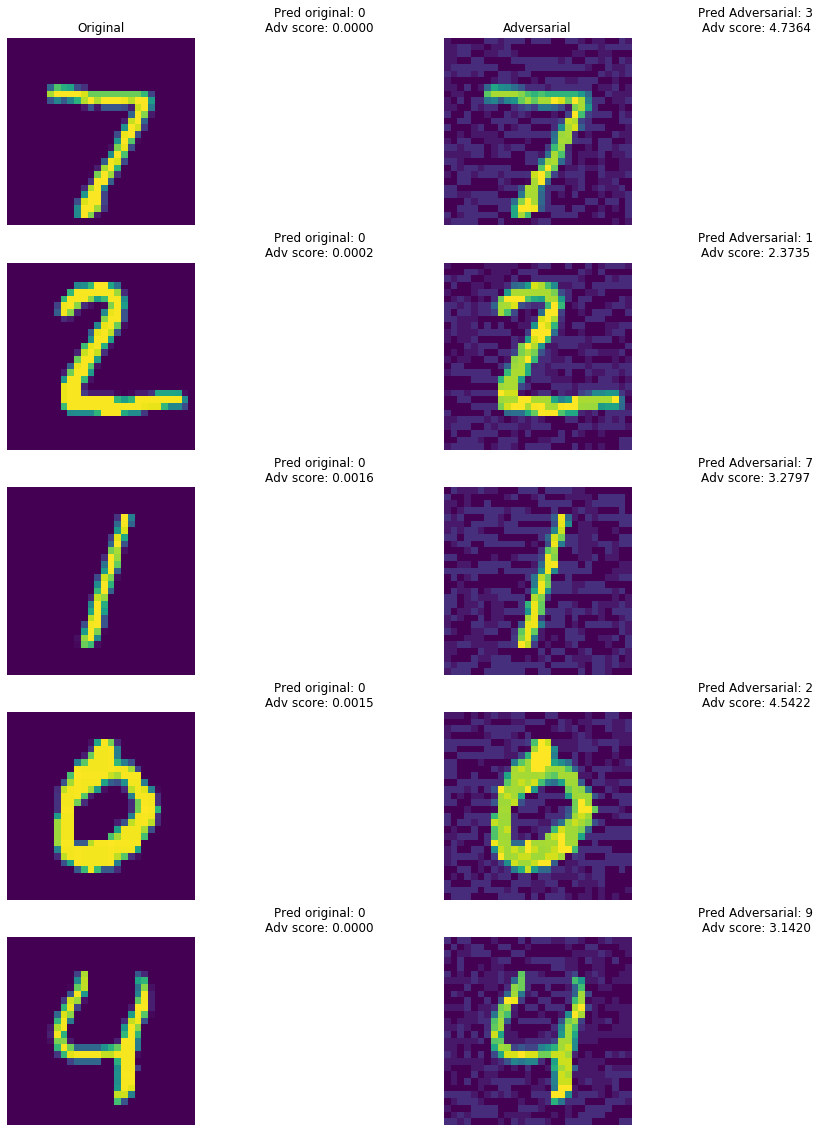

In [207]:
scores = ad_preds['data']['instance_score']
fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')  
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    #class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    #image = Image.fromarray(class_image, 'RGB')
    #image = np.array(image)
    #ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'
                  '\nAdv score: {:.4f}'.format(y_pred[row], scores[row]))    
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    #class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    #image_adv = Image.fromarray(class_image_adv, 'RGB')
    #image_adv = np.array(image_adv)   
    #ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred Adversarial: {}'
                  '\nAdv score: {:.4f}'.format(y_pred_adv[row], scores[row + nb_adv]))    
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

In [208]:
nb_adv

100

In [209]:
kl_test_dict = ad.predict(X_val[:nb_adv], return_instance_score=True)
kl_test = kl_test_dict['data']['instance_score']
kl_adv_dict = ad.predict(X_val[nb_adv:], return_instance_score=True)
kl_adv = kl_adv_dict['data']['instance_score']

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [210]:
print(kl_test.shape, kl_adv.shape)
print(kl_test.mean(), kl_test.std())
print(kl_adv.mean(), kl_adv.std())

(100,) (100,)
0.05332961 0.22031035
2.9016984 1.5406144


### All samples

In [211]:
preds_ad_test = kl_test_dict['data']['is_adversarial']
preds_ad_adv = kl_adv_dict['data']['is_adversarial']
preds_ad = np.concatenate((preds_ad_test, preds_ad_adv))
y_true_ad = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv))))

In [212]:
preds_ad_adv.shape

(100,)

In [213]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad, preds_ad))

Adversarial detection accuracy: 0.95


In [214]:
print('Adversarial detection f1:', f1_score(y_true_ad, preds_ad))

Adversarial detection f1: 0.9504950495049505


In [215]:
print('Adversarial detection confusion matrix:')
confusion_matrix(y_true_ad, preds_ad)

Adversarial detection confusion matrix:


array([[94,  6],
       [ 4, 96]])

### 100 advesarial samples

In [216]:
idx_sparse = np.random.permutation(len(preds_ad_adv))[:100]
preds_ad_sparse = np.concatenate((preds_ad_test, preds_ad_adv[idx_sparse]))
y_true_ad_sparse = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv[idx_sparse]))))

In [217]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection accuracy: 0.95


In [218]:
print('Adversarial detection f1:', f1_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection f1: 0.9504950495049505


In [219]:
print('Adversarial detection confusion matrix:')
confusion_matrix(y_true_ad_sparse, preds_ad_sparse)

Adversarial detection confusion matrix:


array([[94,  6],
       [ 4, 96]])

### 10 adversarial samples

In [220]:
idx_sparse = np.random.permutation(len(preds_ad_adv))[:10]
preds_ad_sparse = np.concatenate((preds_ad_test, preds_ad_adv[idx_sparse]))
y_true_ad_sparse = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv[idx_sparse]))))

In [221]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection accuracy: 0.9454545454545454


In [222]:
print('Adversarial detection f1:', f1_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection f1: 0.7692307692307693


In [223]:
print('Adversarial detection confusion matrix:')
confusion_matrix(y_true_ad_sparse, preds_ad_sparse)

Adversarial detection confusion matrix:


array([[94,  6],
       [ 0, 10]])

## Curves

In [224]:
def predict_adv(x, tr):
    return (x > tr).astype(int)

def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

def calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=100, nb_sigmas=3):
    
    X_train_samples = np.random.permutation(X_train)[:nb_samples]
    preds_train = predict_fn(X_train_samples)
    nn = NearestNeighbors()
    nn.fit(preds_train)
    
    preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
    dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
    dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

    df_dist = pd.DataFrame()
    df_dist['test'] = dist_test.flatten()
    df_dist['adv'] = dist_adv.flatten()
    
    perc, sigma_plus = _calculate_perc(df_dist, nb_sigmas=nb_sigmas)
    
    return perc, df_dist, sigma_plus

def predict_fn(x):
    return model.predict(x)

In [225]:
perm = np.random.permutation(range(len(kl_adv)))[:]
x_kl = np.concatenate((kl_test, kl_adv[perm]))
y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv[perm]))))
x_kl = x_kl / x_kl.max()

In [226]:
perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_to_adv, X_adv, predict_fn, nb_samples=1000, nb_sigmas=5)
dist_test, dist_adv = df_dist['test'].values, df_dist['adv'].values
x_bl =  np.concatenate((dist_test, dist_adv[perm]))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv[perm]))))
x_bl = x_bl / x_bl.max()

### Precision recall curves

Naive detector baseline


(0.0, 1.0)

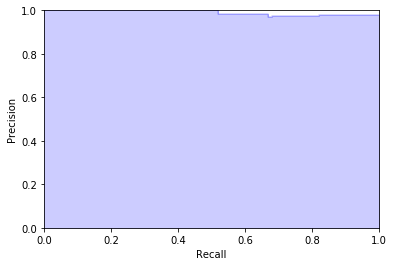

In [227]:
print('Naive detector baseline')
precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_bl, x_bl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_bl, precision_bl, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_bl, precision_bl, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

Vae detector


(0.0, 1.0)

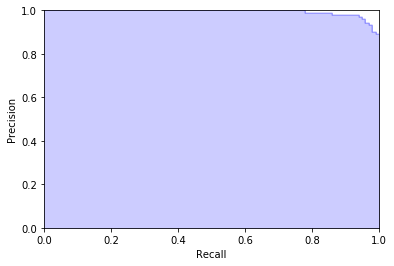

In [228]:
print('Vae detector')
precision, recall, thresholds = precision_recall_curve(y_kl, x_kl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

Vae detector roc


(0.0, 1.0)

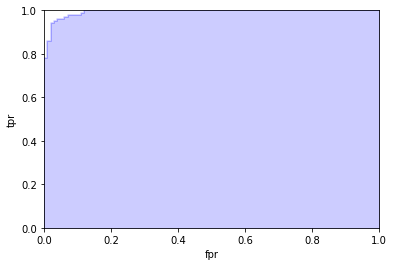

In [229]:
print('Vae detector roc')
fpr, tpr, thresholds = roc_curve(y_kl, x_kl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
plt.fill_between(fpr, tpr, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

In [230]:
roc_auc_score(y_kl, x_kl)

0.9933

### Accuracy - f1 scores

In [127]:
trs = np.arange(0, 1.001, 0.001)
tresholds, precs, recals, accs, f1s = [], [], [], [], []
precs_bl, recals_bl, accs_bl, f1s_bl = [], [], [], []
for tr in trs:
    preds_kl = predict_adv(x_kl, tr)
    preds_bl = predict_adv(x_bl, tr)
    
    prec = precision_score(y_kl, preds_kl)
    rec = recall_score(y_kl, preds_kl)
    acc = accuracy_score(y_kl, preds_kl)
    f1 = f1_score(y_kl, preds_kl)
    
    prec_bl = precision_score(y_bl, preds_bl)
    rec_bl = recall_score(y_bl, preds_bl)
    acc_bl = accuracy_score(y_bl, preds_bl)
    f1_bl = f1_score(y_bl, preds_bl)
    
    tresholds.append(tr)
    precs.append(prec)
    recals.append(rec)
    accs.append(acc)
    f1s.append(f1)
    
    precs_bl.append(prec_bl)
    recals_bl.append(rec_bl)
    accs_bl.append(acc_bl)
    f1s_bl.append(f1_bl)

df_scores = pd.DataFrame()
df_scores['trs'] = tresholds
df_scores['precs'] = precs
df_scores['recs'] = recals
df_scores['accs'] = accs
df_scores['f1s'] = f1s

df_scores['precs_bl'] = precs_bl
df_scores['recs_bl'] = recals_bl
df_scores['accs_bl'] = accs_bl
df_scores['f1s_bl'] = f1s_bl

/home/gio/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gio/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy


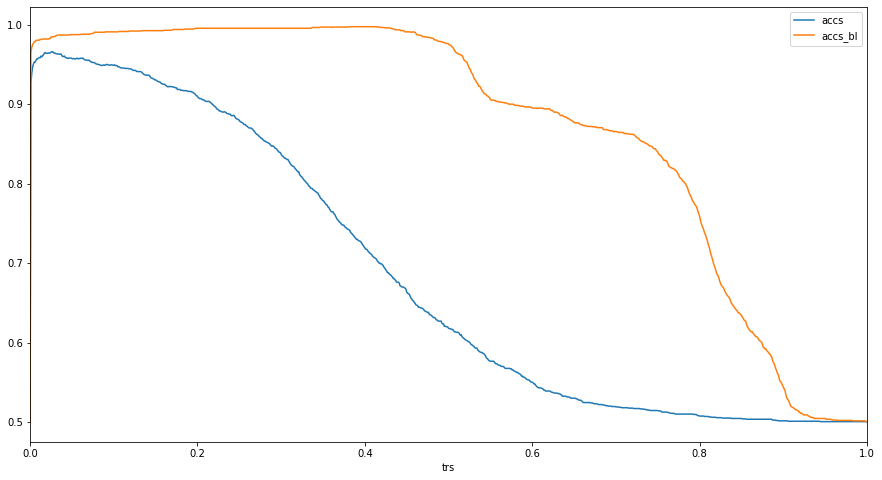

In [128]:
print('Accuracy')
df_scores.plot(x= 'trs',y=['accs', 'accs_bl'], figsize=(15, 8))

F1 score


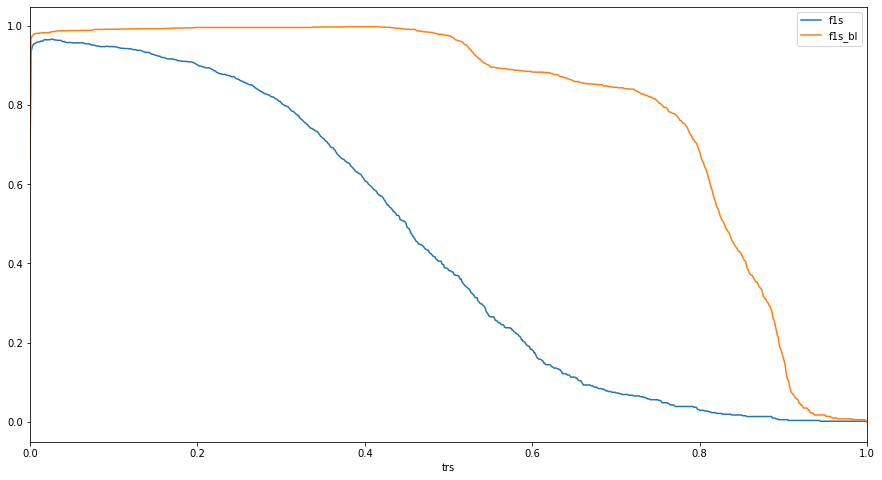

In [129]:
print('F1 score')
df_scores.plot(x= 'trs',y=['f1s', 'f1s_bl'], figsize=(15, 8))

In [130]:
df_scores.describe()

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.500000,0.993081,0.372766,0.683418,0.441342,0.992126,0.754215,0.873398,0.798081
std,0.289108,0.037249,0.361739,0.177069,0.376792,0.036075,0.332610,0.164441,0.310266
min,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000
25%,0.250000,0.995633,0.029000,0.514000,0.056365,0.991080,0.679000,0.837500,0.805970
50%,0.500000,0.998498,0.237000,0.617500,0.382876,0.996319,0.954000,0.974000,0.973388
75%,0.750000,1.000000,0.762000,0.878000,0.861521,1.000000,1.000000,0.994000,0.994036
max,1.000000,1.000000,1.000000,0.966000,0.966203,1.000000,1.000000,0.997500,0.997504


### Distributions

Vae detector


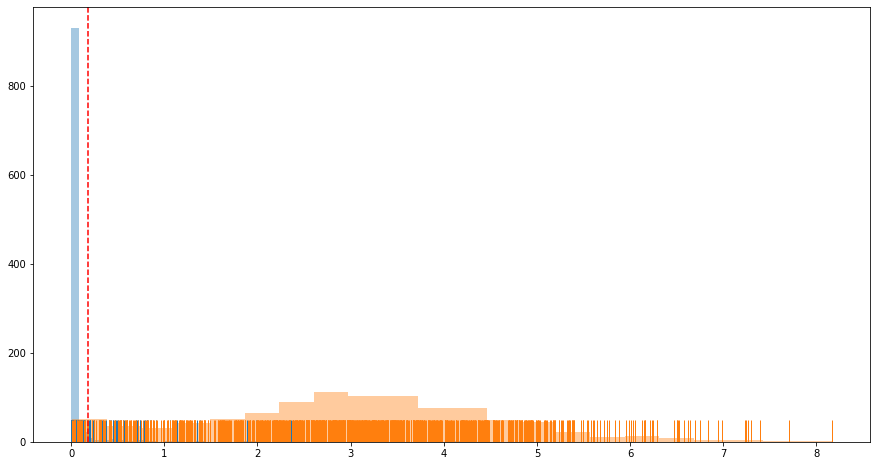

In [131]:
print('Vae detector')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(kl_adv, rug=True,ax=ax, kde=False)

Naive detector baseline


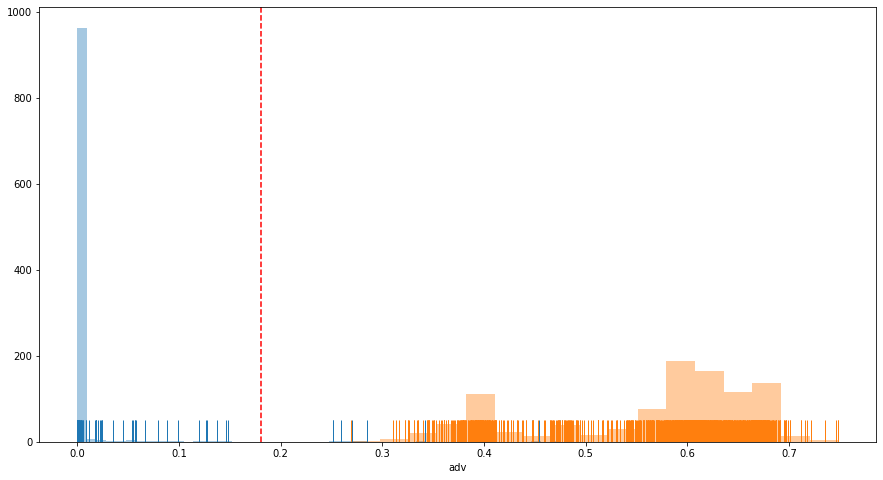

In [132]:
print('Naive detector baseline')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_dist['test'], rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(df_dist['adv'], rug=True,ax=ax, kde=False)

# Model accuracy with adv samples 

In [91]:
preds_adv_test, y_adv_test = generate_adv_set(X_to_adv, X_adv)

In [92]:
accuracy_score(preds_adv_test, y_adv_test)

0.7196048632218845

In [170]:
accuracy_score(preds_orig[:906], y_val_adv[:906])

0.10264900662251655